/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4594 entries, 0 to 4593
Data columns (total 4 columns):
name        4587 non-null object
admin       4594 non-null object
adm0_a3     4594 non-null object
geometry    4594 non-null geometry
dtypes: geometry(1), object(3)
memory usage: 143.6+ KB
None


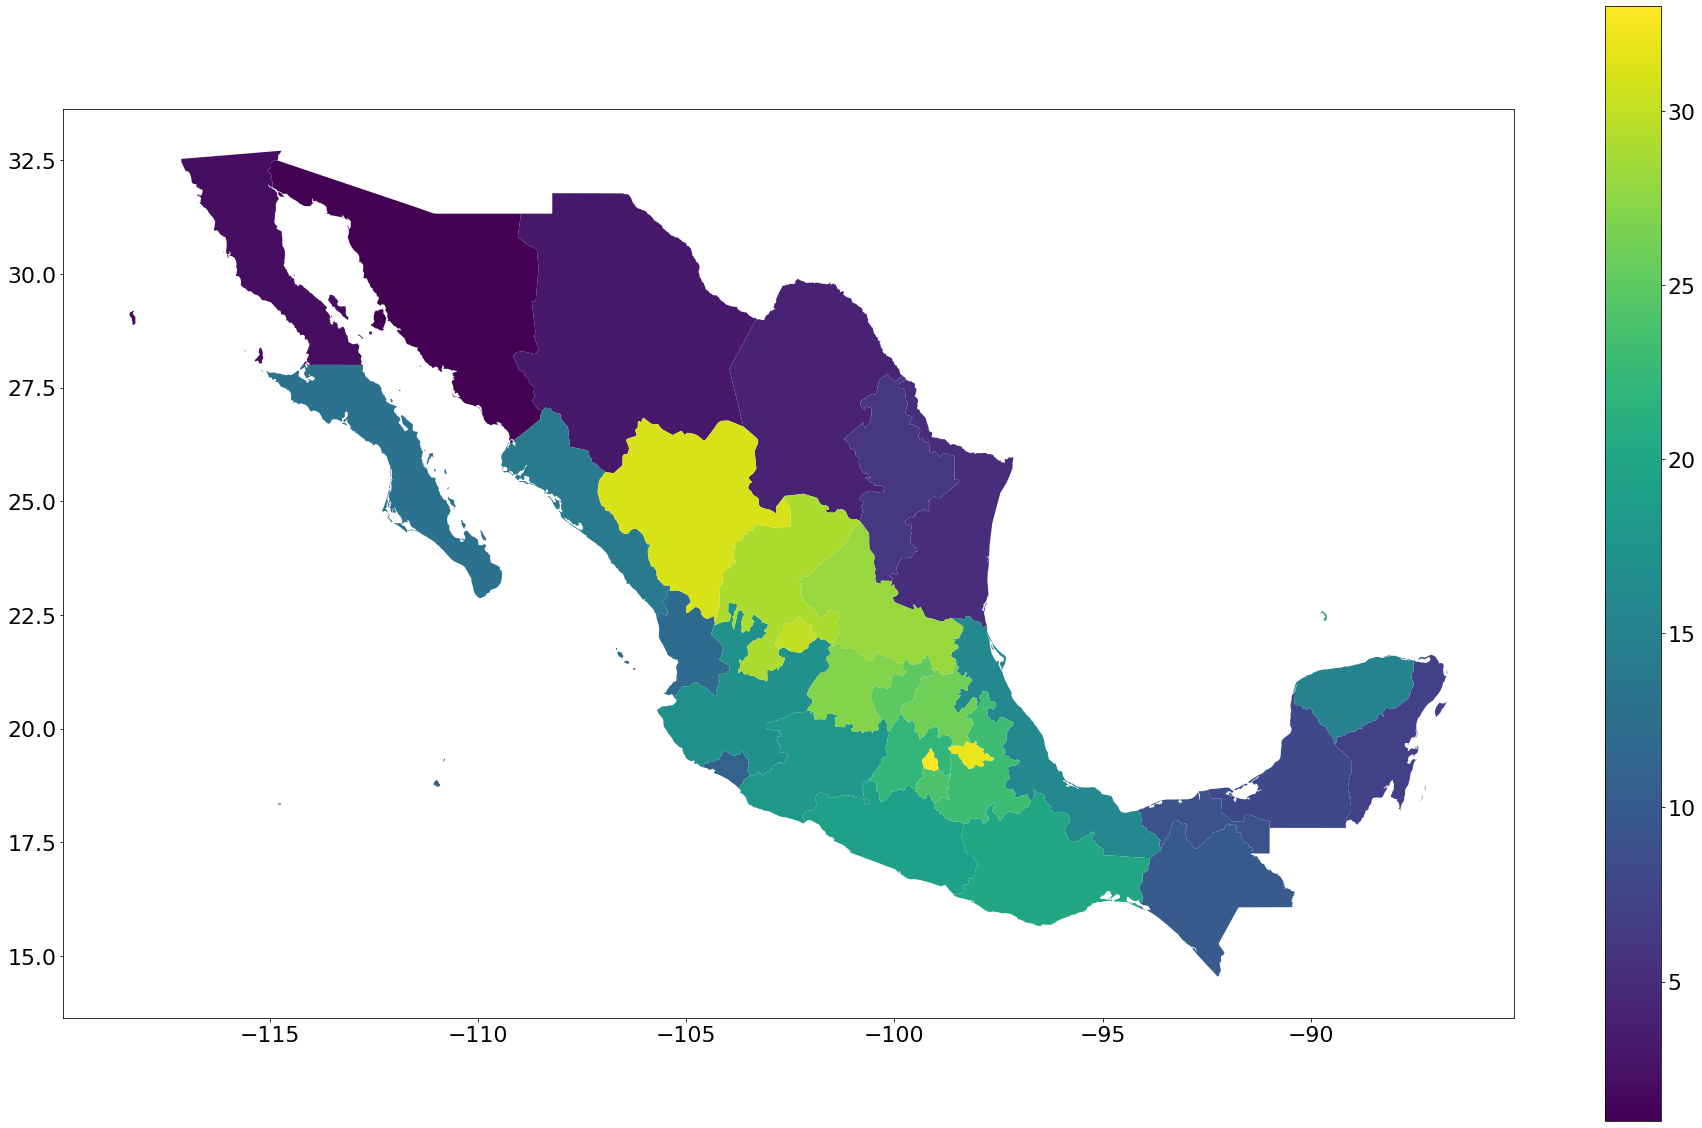

In [13]:
import geopandas as gpd
import pandas as pd
import json
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *

!pwd
!python --version
import metnum

def calculate_metrics(variable_to_predict, df):
    df = df[df['prediction'].notna()]
    return (math.sqrt(mean_squared_error(df[variable_to_predict], df['prediction'])),
            math.sqrt(mean_squared_log_error(df[variable_to_predict]+1, df['prediction']+1)))


def experiment(percentage_of_training_cases,
         variable_to_predict,
         variables_to_study,
         seed, 
         df_old,
         data):
    df = df_old.copy(deep=True)

    t0 = time.time()

    df = df[0:].sample(frac=1, random_state=seed)
    
    #cleanup
    df = df[df[variable_to_predict].notna()]
    for var in variables_to_study:
        df = df[df[var].notna()]
        
    TOTAL_TRAIN_CASES = int(percentage_of_training_cases*len(df))
    
    df_prediction = df[TOTAL_TRAIN_CASES:].copy(deep=True)

    df = df[:TOTAL_TRAIN_CASES]
    
    print('len df_prediction '+len(df_prediction))
    print('len df '+len(df))

    x_train, y_train = df[variables_to_study].values, df[variable_to_predict].values
    x_predict, y_predict = df_prediction[variables_to_study].values, df_prediction[variable_to_predict].values
    
    x_train = x_train.reshape(len(x_train),len(variables_to_study))
    y_train = y_train.reshape(len(y_train),1)
    x_predict = x_predict.reshape(len(x_predict),len(variables_to_study))
    y_predict = y_predict.reshape(len(y_predict),1)

    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x_train, y_train)
    df_prediction['prediction'] = linear_regressor.predict(x_predict)

    t1 = time.time()
    total_time = (t1-t0)
    
    rmse, rmsle = calculate_metrics(variable_to_predict, df_prediction)
    data['rmse'].append(rmse)
    data['rmsle'].append(rmsle)
    data['percentage_of_train_cases'].append(percentage_of_training_cases)
    data['time'].append(total_time)
    
    if(len(variables_to_study)==1):
        sns.scatterplot(data=df, x=variables_to_study[0], y=variable_to_predict)
        sns.lineplot(data=df_prediction, x=variables_to_study[0], y='prediction', color='red')
    elif(len(variables_to_study)==2):
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
        ax.set_xlabel('X', fontsize=15, rotation=150)
        ax.set_ylabel('Y')
        ax.set_zlabel(r'Z', fontsize=15)
        ax.scatter(df_prediction[variables_to_study[0]],
                   df_prediction[variables_to_study[1]],
                   df_prediction['prediction'], c='skyblue', s=60)
        ax.plot_trisurf(df_prediction[variables_to_study[0]], 
                        df_prediction[variables_to_study[1]], 
                        df_prediction['prediction'], cmap=plt.cm.viridis, linewidth=0.2)
        plt.show()
    return df_prediction

df = pd.read_csv('../data/train.csv')

shapefile = 'ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['name','admin','adm0_a3', 'geometry']]
#Rename columns.

print(gdf.info())
gdf.columns = ['province','country', 'country_code', 'geometry']

gdf = gdf[gdf['country'] == 'Mexico']

provinces = gdf['province'].unique()

gdf.head()

data = [] 

i=1
for province in provinces:
    data.append([province,i])
    i = i+1
  
# Create the pandas DataFrame 
df_age = pd.DataFrame(data, columns = ['province','Age'])

merged = gdf.merge(df_age, left_on = 'province', right_on = 'province')

merged.head()

plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(32.5, 20.5, forward=True)
merged.plot(column='Age', ax=ax, legend=True)

# df_ciudades = df.copy(deep=True)
# df_provincias = df.copy(deep=True)
# df_idzona = df.copy(deep=True)

# df_ciudades = df_ciudades[df_ciudades['ciudad'].notna()]
# df_provincias = df_provincias[df_provincias['provincia'].notna()]
# df_idzona = df_idzona[df_idzona['provincia'].notna()]

# print(len(df_ciudades['ciudad'].unique()))
# print(len(df_ciudades['ciudad']))
# print("---prov----")
# print(len(df_ciudades['provincia'].unique()))
# print(len(df_ciudades['provincia']))
# print("---idzona----")
# print(len(df_idzona['idzona'].unique()))
# print(len(df_idzona['idzona']))
# print(df_idzona['idzona'][0:2])

# provincias = df_ciudades['provincia'].unique()

# folder='./test_precio_y_provincia_{}'.format(int(time.time()))

# os.mkdir(folder)
# for provincia in provincias:
#     d = {'rmse' : [], 'rmsle' : [], 'percentage_of_train_cases' : [], 'time' : []}
#     df_provincia = df_provincias.copy(deep=True)
#     df_provincia = df_provincia[df_provincia['provincia'] == provincia ]
#     for j in np.arange(1,21,1):
#    #     for i in np.arange(0.6, 0.96, 0.05):
#    #     print(i)
#         df_prediction = experiment(0.9, 'precio', ['metroscubiertos'], j, df_provincia, d)
#         df_prediction.to_csv(folder+'/prediction_'+provincia+'_'+str(j)+'.csv', 
#                                  encoding='utf-8', index=False)
#         print('\n-------'+str(j)+'-------\n')
            
#     (pd.DataFrame(data=d)
#         .to_csv(folder+'/error_'+provincia+'.csv', encoding='utf-', index=False))
